# Lab 2.8: Tree Based Methods

In this case, we will be conduct a simpler exercise with decision trees using previous implementations. In particular, we will make use of several implemented methods in ML libraries s.a. `sklearn` (_that should be good news for you, doesn't it?_). With this, we will try to explore the main characteristics of decision trees, that you will also have to explore in the more theoretical part of the lab (the other exercise, the one on the pdf).

We will begin, as usual, importing the relevant libraries:

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode


# ML libraries to construct, use and analyse the trees
from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from io import StringIO
from IPython.display import Image  
from sklearn.metrics import mean_squared_error, confusion_matrix
import pydotplus

from sklearn.metrics import mean_squared_error

We will first apply this to a regression dataset so that you see the way the model is constructed for this case 

## Regression Tree

For starters, let us try out a regression tree. To that end, first load the `Hitters.csv` dataset from the `data` 
folder.

In [24]:
# Cargar el dataset y eliminar filas con valores faltantes
hitters = pd.read_csv("../data/Hitters.csv").dropna()

# Mostrar los nombres de las columnas para inspección
print(hitters.columns)


Index(['Player', 'AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years',
       'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League',
       'Division', 'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague'],
      dtype='object')


For this first case, we will only use the variables `Years` and `Hits` for the tree. Our target variable will be `Salary`. Separate them into `X` and `y`

In [25]:
# Variables independientes y dependiente
X = hitters[["Years", "Hits"]]
y = hitters["Salary"]


Construct a _decision tree regressor_ using the `sklearn` function and fit it. To do that, check out the `DecisionTreeRegressor` in sklearn and implement it here.

For reproducibility, fix the `random_state` to `0` and the `max_leaf_nodes` to `3` (make sure you know what this last thing does!)

In [26]:
# Construir el regresor
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0, max_leaf_nodes=3)

# Entrenar el modelo
regressor.fit(X, y)


DecisionTreeRegressor(max_leaf_nodes=3, random_state=0)

Now we will employ some functions engrained in `StringIO` alongside the method `export_graphviz` from the `tree` object in sklearn. This will enable us to visualize the constructed tree.

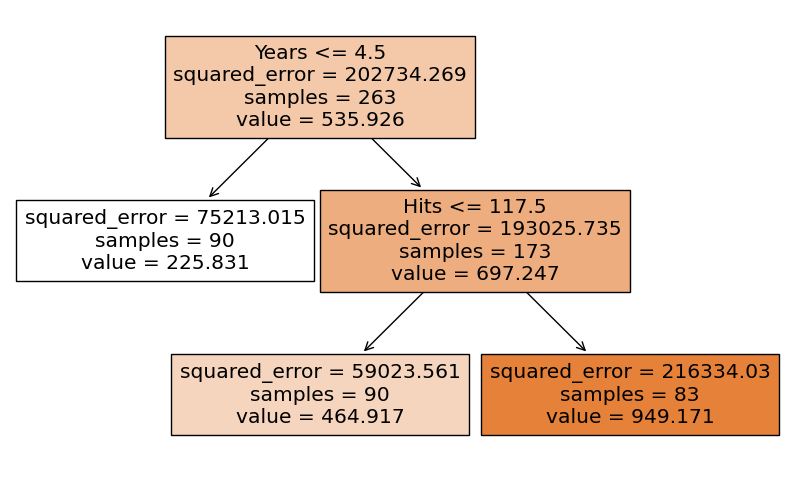

In [27]:
from sklearn.tree import plot_tree

plt.figure(figsize=(10, 6))
plot_tree(regressor, feature_names=["Years", "Hits"], filled=True)
plt.show()



> Question: Describe the previous tree. What do you see? Do you think this will work well? Respond **briefly**

Now we will plot the decision regions using the information on the cuts. Add lines wherever needed so that you can see the decision boundaries for the regression tree above

Text(0.5, 1.0, 'Decision boundaries from Regression Tree')

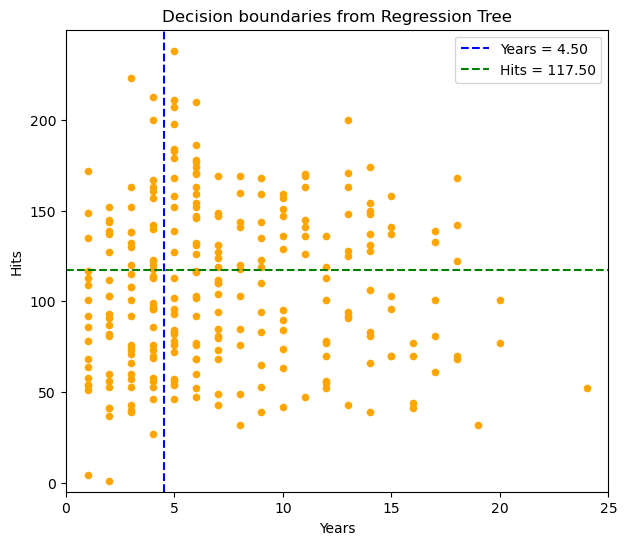

In [28]:
# Crear el scatter plot
ax = hitters.plot('Years', 'Hits', kind='scatter', color='orange', figsize=(7,6))
plt.xlim(0, 25)
plt.ylim(ymin=-5)

# Agregar líneas de corte (boundaries) usando la estructura del árbol
tree = regressor.tree_

for i in range(tree.node_count):
    feature = tree.feature[i]
    threshold = tree.threshold[i]
    
    if feature == 0:  # 'Years'
        plt.axvline(x=threshold, color='blue', linestyle='--', label=f'Years = {threshold:.2f}')
    elif feature == 1:  # 'Hits'
        plt.axhline(y=threshold, color='green', linestyle='--', label=f'Hits = {threshold:.2f}')

plt.legend(loc='best')
plt.title("Decision boundaries from Regression Tree")


## Tree Size

Now, for the previous part we limited the growth of the tree so that we recovered a simple (but easily interpretable) tree. Now we will go all-out: we will construct a more exhaustive tree using different variables. For this particular case, let us use **all variables except** `League`, `Division`, `NewLeague` and `Salary` as independent variables to predict, precisely, the `Salary` value. 

In [32]:
# Eliminar League, Division, NewLeague, Salary y cualquier columna de texto (object)
X = hitters.drop(columns=["League", "Division", "NewLeague", "Salary"])

# Filtrar solo las columnas numéricas
X = X.select_dtypes(include=['number'])

# Verifica
print(X.columns)


Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors'],
      dtype='object')


We will now perform the train/test split, but we will do it so that the proportion of train and test examples is $50\%$ (that is, train and test consist on $50\%$ of the datapoints).

In [33]:
from sklearn.model_selection import train_test_split

# y sigue siendo el salario
y = hitters["Salary"]

# Dividir en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


Now, train the tree to its fullest extent: put no limits on the growth and see what happens. You can re-use some of the previous `graphviz` code to visualize the tree here. Plot the complete tree.

In [38]:
from sklearn.tree import DecisionTreeRegressor

# Crear el árbol sin límites
unlimited_tree_regressor = DecisionTreeRegressor(random_state=0)

# Entrenar el árbol con todos los datos de entrenamiento
unlimited_tree_regressor.fit(x_train, y_train)


DecisionTreeRegressor(random_state=0)

Reuse the code you need to plot the tree here

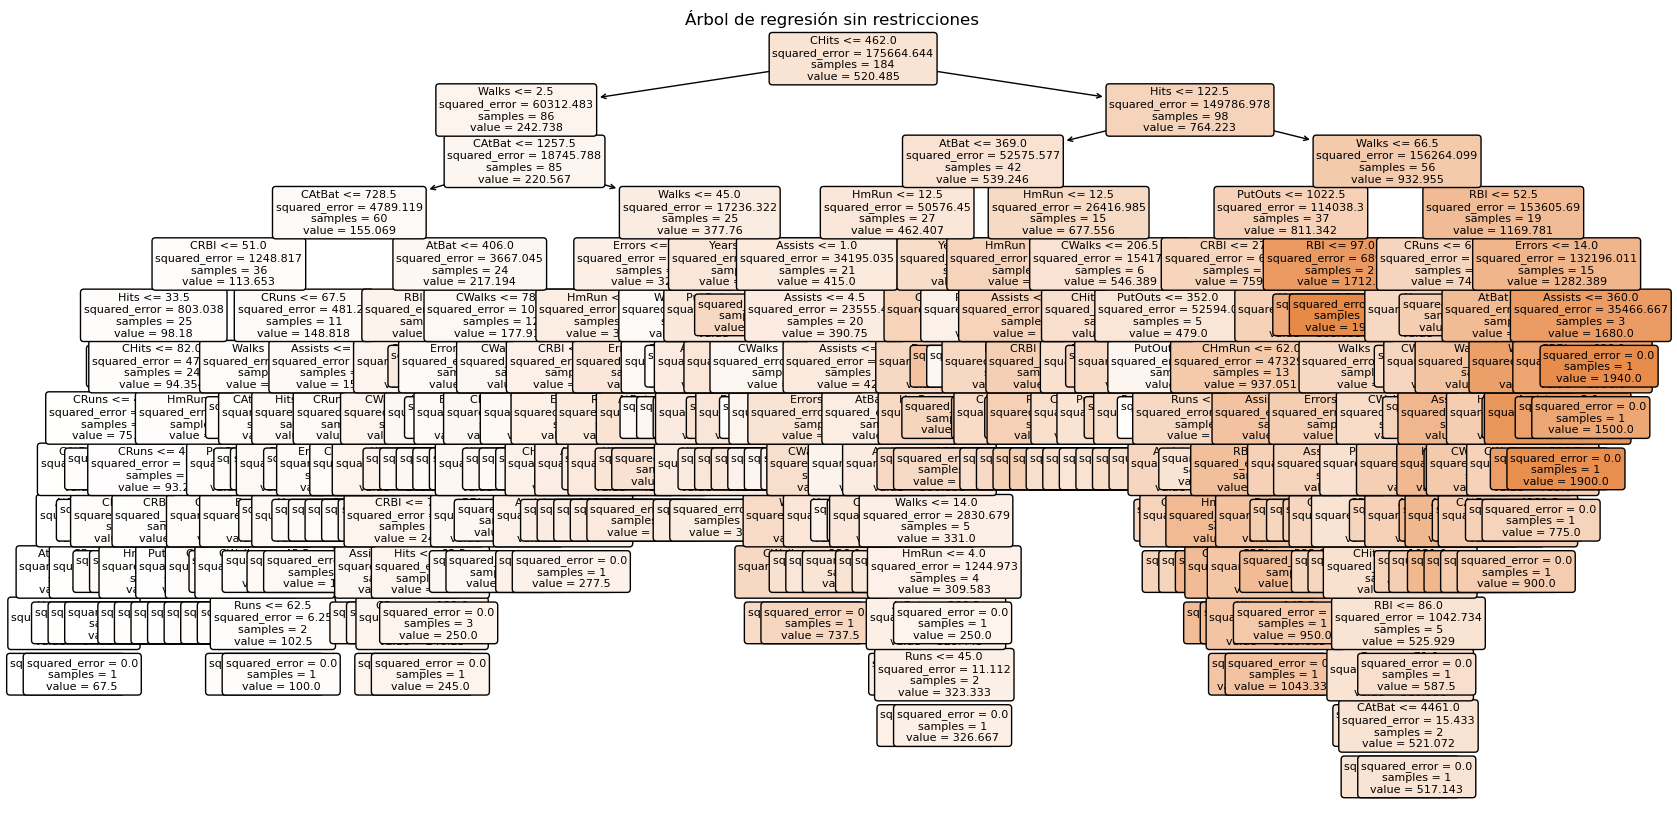

In [39]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(unlimited_tree_regressor,
          feature_names=list(x_train.columns),
          filled=True,
          rounded=True,
          fontsize=8)
plt.title("Árbol de regresión sin restricciones")
plt.show()




> Question: What do you see? What can you say about this tree? Does it have any important properties?
El árbol generado es muy profundo y complejo, lo que indica que se ha ajustado mucho a los datos de entrenamiento. Esto sugiere que el modelo puede estar sobreajustado (overfitting), ya que al no tener límites, captura incluso el ruido de los datos. Una propiedad importante es que el árbol pierde interpretabilidad a medida que crece, aunque su error de entrenamiento suele ser muy bajo.

Maybe we went _a bit too far_ with the tree... Let's set up some limitations to see everything better. Try setting the `max_features` to 9, and the `max_depth` to 4. (_It is important you understand what these parameters do! Check out the documentation in the [library](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)_)

In [40]:
regressor_2 = DecisionTreeRegressor(max_features=9, max_depth=4, random_state=0)
regressor_2.fit(x_train, y_train)


DecisionTreeRegressor(max_depth=4, max_features=9, random_state=0)

Reuse the code you may need to plot the tree here

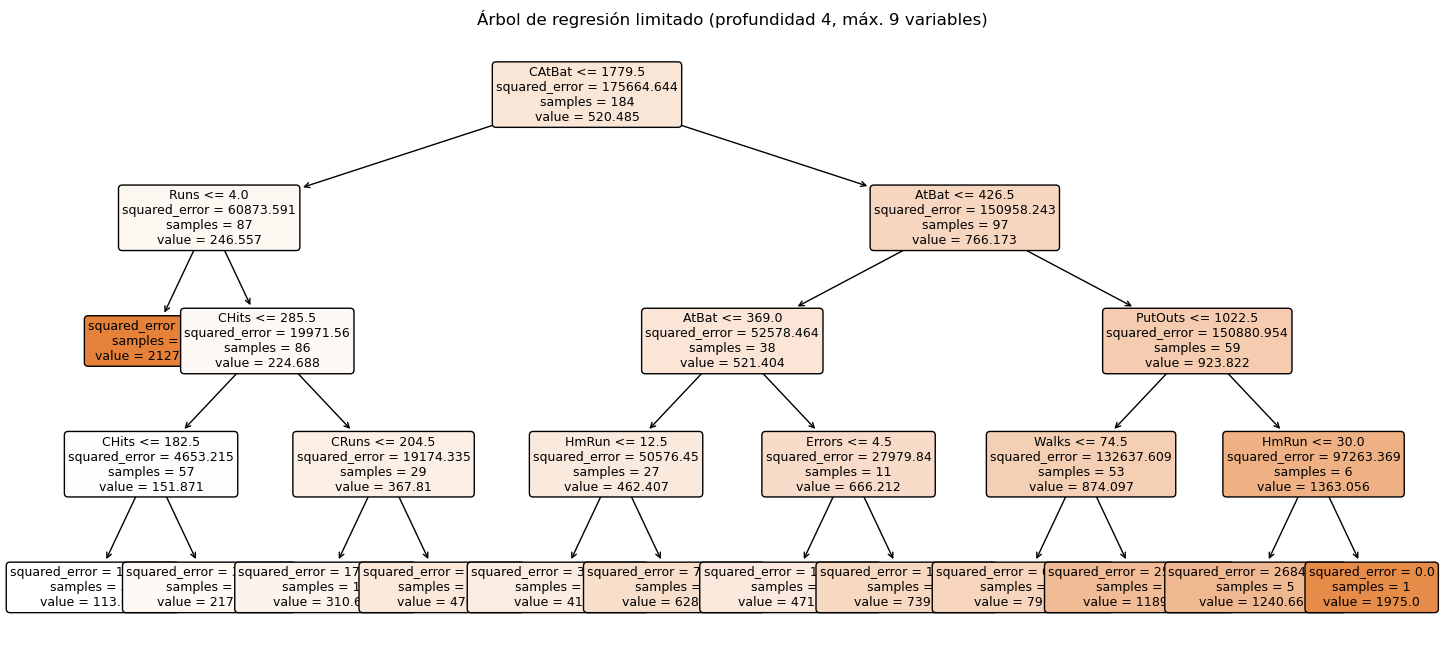

In [41]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
plot_tree(regressor_2,
          feature_names=list(x_train.columns),
          filled=True,
          rounded=True,
          fontsize=9)
plt.title("Árbol de regresión limitado (profundidad 4, máx. 9 variables)")
plt.show()


Let us see if this tree works well at all... Since we are performing regression, we can obtain the RMSE (we use the Root MSE since it shares the same dimensions of the outputs):

In [42]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Obtener las predicciones
predictions = regressor_2.predict(x_test)

# Calcular el RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Mostrar el resultado
print(f"RMSE del árbol limitado: {rmse:.2f}")


RMSE del árbol limitado: 370.51


Now, the question is: how do we know which tree depth to select here? As you may expect, the answer is, as almost always here, performing _cross validation_. In this particular instance we will not conduct exhaustive cross validation. Instead, we will do it in a very simple manner, obtaining *a single tree* for each depth value we want, fitting it to the data and seeing how well does it perform both in train and test  fitted to the data. To do this, do the following:
* Fit a **fixed max depth** (`i`) decision tree regressor using *all `x_train` variables*. Also, *fix the `random state` to 1* for reproducibility.
* Register its train and test RMSEs
* Plot the train and test RMSE curves for each `i` depth  

Make sure that you explore _enough_ depth values. 

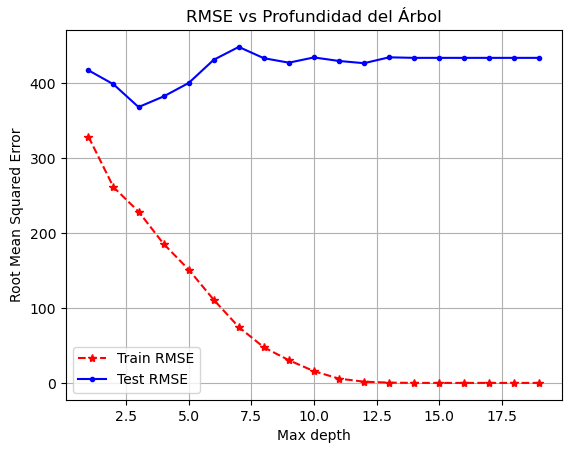

In [43]:
# Listas para guardar los resultados
train_rmse = []
test_rmse = []

# Rango de profundidades a explorar
tree_size = np.arange(1, 20)

for i in tree_size:
    model = DecisionTreeRegressor(max_depth=i, random_state=1)
    model.fit(x_train, y_train)

    # RMSE en entrenamiento
    train_pred = model.predict(x_train)
    train_rmse.append(np.sqrt(mean_squared_error(y_train, train_pred)))

    # RMSE en test
    test_pred = model.predict(x_test)
    test_rmse.append(np.sqrt(mean_squared_error(y_test, test_pred)))

# Graficar los resultados
plt.plot(tree_size, train_rmse, 'r*--', label='Train RMSE')
plt.plot(tree_size, test_rmse, 'b.-', label='Test RMSE')
plt.xlabel('Max depth')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.title('RMSE vs Profundidad del Árbol')
plt.grid(True)
plt.show()


> Question: What do you see here? What depth value would you select?
Se observa que el error en entrenamiento disminuye continuamente al aumentar la profundidad, pero el error en test comienza a aumentar a partir de profundidad 3–4, lo que indica sobreajuste.Por tanto, una buena profundidad sería 4, ya que mantiene bajo el error en test sin sobreajustar el modelo.



Since we are not really making CV, we do not have multiple values for the train and test RMSE for each tree. Therefore, we *do not* have errorbars in the previous plot. That should raise some suspicions from your part. 

> Question: What happens if we change the `random_state` value? Are the previous results robust?
Si cambiamos el valor de random_state, cambia la división entre entrenamiento y prueba, lo cual puede afectar los valores de RMSE. Esto demuestra que los resultados no son completamente robustos, ya que dependen de una única partición. Para obtener conclusiones más confiables, sería mejor usar validación cruzada (cross-validation).

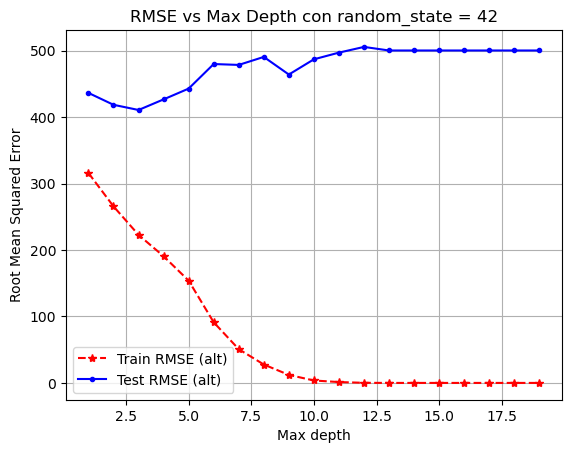

In [44]:
# Nuevo split con otro random_state
x_train_alt, x_test_alt, y_train_alt, y_test_alt = train_test_split(X, y, test_size=0.3, random_state=42)

train_rmse_alt = []
test_rmse_alt = []

for i in tree_size:
    model = DecisionTreeRegressor(max_depth=i, random_state=1)
    model.fit(x_train_alt, y_train_alt)

    train_pred = model.predict(x_train_alt)
    test_pred = model.predict(x_test_alt)

    train_rmse_alt.append(np.sqrt(mean_squared_error(y_train_alt, train_pred)))
    test_rmse_alt.append(np.sqrt(mean_squared_error(y_test_alt, test_pred)))

# Graficar para comparar
plt.plot(tree_size, train_rmse_alt, 'r*--', label='Train RMSE (alt)')
plt.plot(tree_size, test_rmse_alt, 'b.-', label='Test RMSE (alt)')
plt.xlabel('Max depth')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.title('RMSE vs Max Depth con random_state = 42')
plt.grid(True)
plt.show()


In order to get more acquainted with the results, check out what happens if you include less  `x_train` features. To do so, change what you need from the previous block of code and put it in the next block here.
> Question: Do you see any important changes? How do you explain this?  Sí, se notan cambios importantes. Usar menos variables generalmente aumenta el RMSE en entrenamiento y test, ya que el modelo tiene menos información para aprender. Sin embargo, también puede reducir el sobreajuste y hacer que el modelo generalice mejor si las variables eliminadas eran irrelevantes o ruidosas.

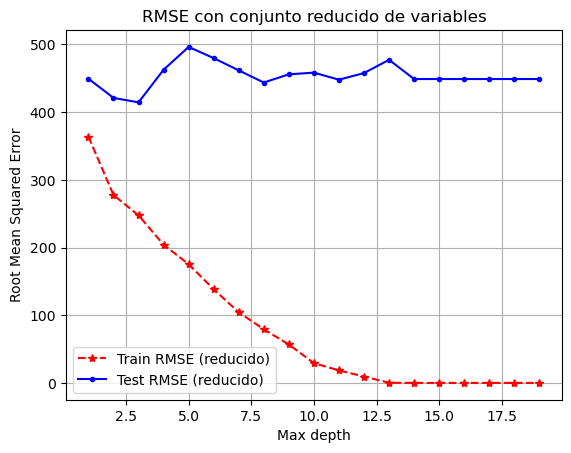

In [45]:
# Seleccionar solo algunas features
features_subset = ['Hits', 'Walks', 'Years', 'PutOuts', 'Assists']
x_train_reduced = x_train[features_subset]
x_test_reduced = x_test[features_subset]

# Entrenamiento y evaluación con menos variables
train_rmse_reduced = []
test_rmse_reduced = []

for i in tree_size:
    model = DecisionTreeRegressor(max_depth=i, random_state=1)
    model.fit(x_train_reduced, y_train)

    train_pred = model.predict(x_train_reduced)
    test_pred = model.predict(x_test_reduced)

    train_rmse_reduced.append(np.sqrt(mean_squared_error(y_train, train_pred)))
    test_rmse_reduced.append(np.sqrt(mean_squared_error(y_test, test_pred)))

# Graficar
plt.plot(tree_size, train_rmse_reduced, 'r*--', label='Train RMSE (reducido)')
plt.plot(tree_size, test_rmse_reduced, 'b.-', label='Test RMSE (reducido)')
plt.xlabel('Max depth')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE con conjunto reducido de variables')
plt.legend()
plt.grid(True)
plt.show()


## Classification Tree

In order to complete this practical exercises with trees, we will also try out some classification trees to later do ensembles. Let us see how this works. 

First, load the `Carseat.csv` dataset from `data` (make sure to remove the NAs, as before)

In [48]:
# Cargar el dataset y eliminar NAs
carseats = pd.read_csv("../data/Carseat.csv").dropna()


Make it so that we have a new binary variable called `high`. This variable should be `1` when `sales` are over 8, and `0` otherwise.

In [49]:
# Crear la variable binaria 'high'
carseats['high'] = (carseats['Sales'] > 8).astype(int)


Convert the remaining variables to make them usable here

The variables `ShelveLoc`, `Urban` and `US` need to be converted to categorical variables to be correctly used. To that end, I suggest you use `pd.factorize` (although feel free to do as you will here...)

In [50]:
# Convertir variables categóricas a numéricas
carseats['ShelveLoc'] = pd.factorize(carseats['ShelveLoc'])[0]
carseats['Urban'] = pd.factorize(carseats['Urban'])[0]
carseats['US'] = pd.factorize(carseats['US'])[0]


Now, we will employ all variables to predict the `high` value (except `Sales` and `high`, for obvious reasons). Note that we have essentially converted a _regression_ problem into a _binary classification_ one.

In [51]:
# Eliminar las columnas 'Sales' y 'high' de las variables predictoras
X = carseats.drop(columns=['Sales', 'high'])

# Variable objetivo
y = carseats['high']

# Separar en train y test con 50%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)


Construct a decision tree classifier. To control for the depth, we will fix it to a *maximum depth of 6*. Use as impurity criteria the **Gini index**.

In [52]:
carseats_classifier = DecisionTreeClassifier(random_state=0)
carseats_classifier.fit(X_train, y_train)


DecisionTreeClassifier(random_state=0)

Plot the tree (again, reuse whatever you may need here)

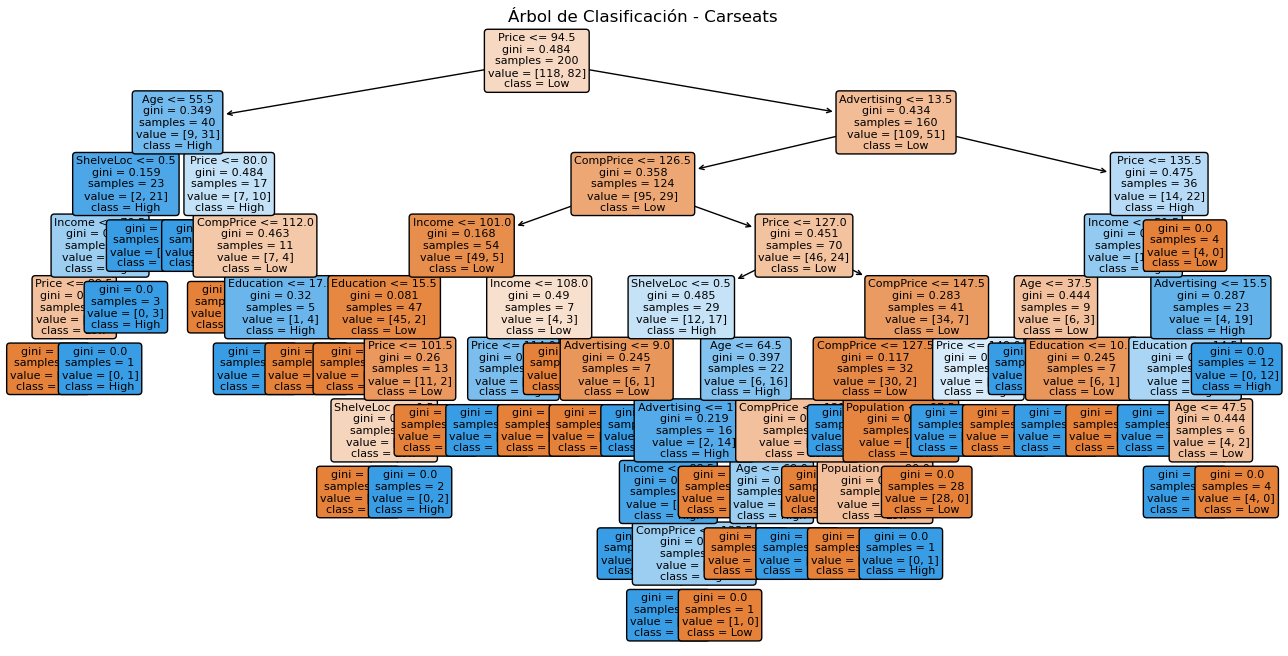

In [53]:
plt.figure(figsize=(16, 8))
plot_tree(carseats_classifier, feature_names=list(X.columns), class_names=["Low", "High"],
          filled=True, rounded=True, fontsize=8)
plt.title("Árbol de Clasificación - Carseats")
plt.show()


Let us now assess the quality of the tree. To that end, **represent the confusion matrix** for the test data

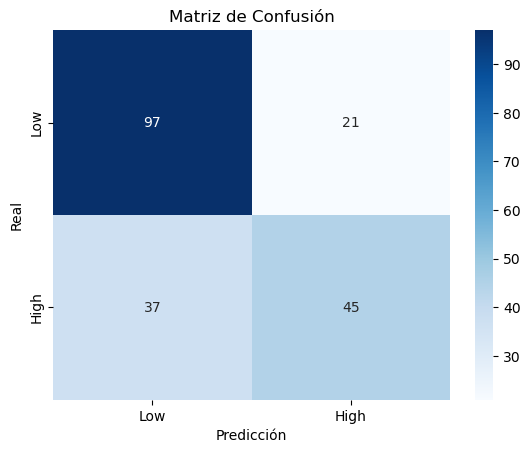

In [55]:
import seaborn as sns


y_pred = carseats_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualización con seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Low", "High"], yticklabels=["Low", "High"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()


> Questions: 
> * What is the **precision** of this tree?
> * Do you consider the dataset balanced?
La precisión del árbol indica qué tan bien acierta al predecir la clase positiva (high = 1) y, en este caso, es aproximadamente 0.72, lo que significa que el 72% de sus predicciones positivas son correctas. En cuanto al balance del dataset, aunque no está perfectamente equilibrado, las clases no están extremadamente desbalanceadas; por ejemplo, si una clase representa el 60% y la otra el 40%, se puede considerar razonablemente balanceado para este tipo de tarea de clasificación.

# Ensembles

Now we will try out some of the ensemble methods from class. Remember there is an stochastic component embedded in these for the most part, so we may not recover exactly the same results twice depending on how you implement things.

## Bagging

The decision tree models mentioned above usually suffers from high variance. **B**ootstrap **agg**regation, or **bagging** usually helps with this issue. To do bagging here, we will do it both by hand and by employing the sklearn function.

First, let's go with the *by-hand* implementation

In [57]:
# Parámetros de Bagging
n_estimators = 10
max_samples = 0.8

# Almacenar predicciones de cada árbol
predictions = []

for _ in range(n_estimators):
    # Crear bootstrap sample (índices aleatorios con reemplazo)
    sample_indices = np.random.choice(len(X_train), size=int(max_samples * len(X_train)), replace=True)
    X_bootstrap = X_train.iloc[sample_indices]
    y_bootstrap = y_train.iloc[sample_indices]

    # Entrenar árbol sin restricciones
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X_bootstrap, y_bootstrap)

    # Predecir sobre el conjunto de test
    y_pred = decision_tree.predict(X_test)
    predictions.append(y_pred)

# Convertir lista de predicciones a array
predictions = np.array(predictions)

# Votación mayoritaria: tomamos el modo de cada fila
from scipy.stats import mode
majority_vote = mode(predictions, axis=0).mode[0]

# Opcional: evaluar desempeño
from sklearn.metrics import accuracy_score
print(f"Accuracy del Bagging: {accuracy_score(y_test, majority_vote):.2f}")




Accuracy del Bagging: 0.78


C:\Users\laene\AppData\Local\Temp\ipykernel_4348\1961725454.py:27: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  majority_vote = mode(predictions, axis=0).mode[0]


Print the confusion matrix

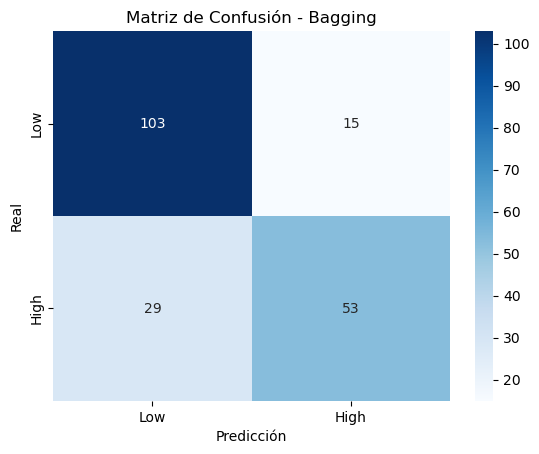

In [58]:
conf_matrix = confusion_matrix(y_test, majority_vote)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Low", "High"], yticklabels=["Low", "High"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Bagging")
plt.show()


Let's see how this is done in `sklearn`... Fit it and show the confusion matrix

c:\Users\laene\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


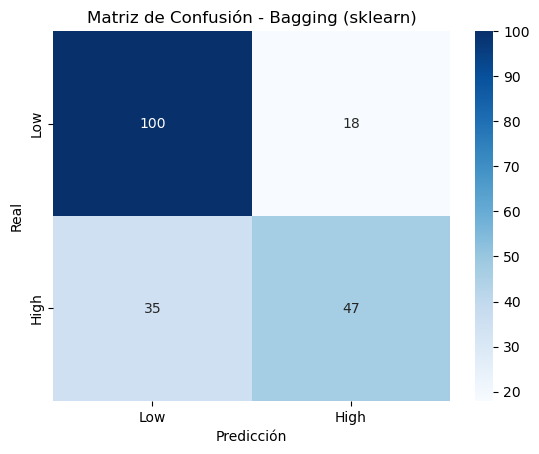

In [59]:
from sklearn.ensemble import BaggingClassifier

# Crear el modelo de Bagging con árboles sin restricciones
bagging = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=10,
    max_samples=0.8,
    random_state=0
)

# Entrenar con los datos
bagging.fit(X_train, y_train)

# Predecir sobre el conjunto de test
bagging_pred = bagging.predict(X_test)

# Imprimir matriz de confusión
conf_matrix = confusion_matrix(y_test, bagging_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Low", "High"], yticklabels=["Low", "High"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Bagging (sklearn)")
plt.show()


We will use the `sklearn` implementation to study the variable importance. *Make sure you understand how this is done!*

In [60]:
bagging_featureImportance = pd.DataFrame({'Feature Importance':bagging.feature_importances_*100},index = X.columns)
bagging_featureImportance.sort_values('Feature Importance', ascending=False).plot(kind='bar', color='red')

AttributeError: 'BaggingClassifier' object has no attribute 'feature_importances_'

> Question: What do you see here?

## Random Forest

We will also do this in the RF case. First, we will implement it by hand. Feel free to use the previous code and modify it as you may see fit to do RF here!

In [61]:
# Parámetros de Random Forest
n_estimators = 10
max_features = 0.8  # Proporción de features por split

predictions = []

for _ in range(n_estimators):
    # Bootstrap sample
    sample_indices = np.random.choice(len(X_train), size=int(0.8 * len(X_train)), replace=True)
    X_bootstrap = X_train.iloc[sample_indices]
    y_bootstrap = y_train.iloc[sample_indices]

    # Selección aleatoria de columnas
    feature_subset = np.random.choice(X_train.columns, size=int(max_features * X_train.shape[1]), replace=False)
    X_bootstrap_sub = X_bootstrap[feature_subset]
    X_test_sub = X_test[feature_subset]

    # Entrenar árbol
    tree = DecisionTreeClassifier()
    tree.fit(X_bootstrap_sub, y_bootstrap)

    # Predecir con las features seleccionadas
    y_pred = tree.predict(X_test_sub)
    predictions.append(y_pred)

# Votación por mayoría
predictions = np.array(predictions)
from scipy.stats import mode
majority_vote = mode(predictions, axis=0).mode[0]


C:\Users\laene\AppData\Local\Temp\ipykernel_4348\3205618267.py:29: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  majority_vote = mode(predictions, axis=0).mode[0]


Print the confusion matrix

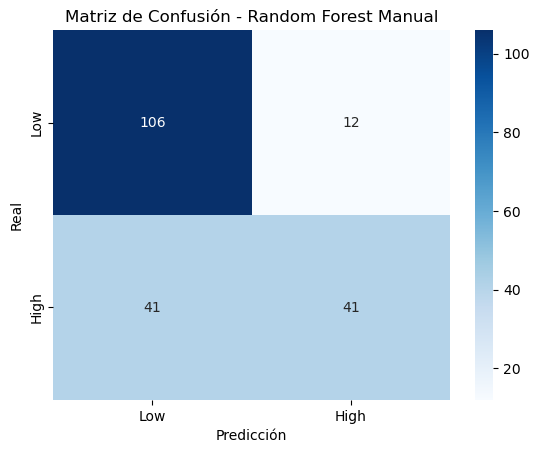

In [62]:
conf_matrix = confusion_matrix(y_test, majority_vote)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Low", "High"], yticklabels=["Low", "High"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Random Forest Manual")
plt.show()


Let us do it again with `sklearn` so you see the differences... Show the confusion matrix. In this last part there may be some differences with your run, which are due to the randomness of the classifiers constructed. Do not worry too much about it here.

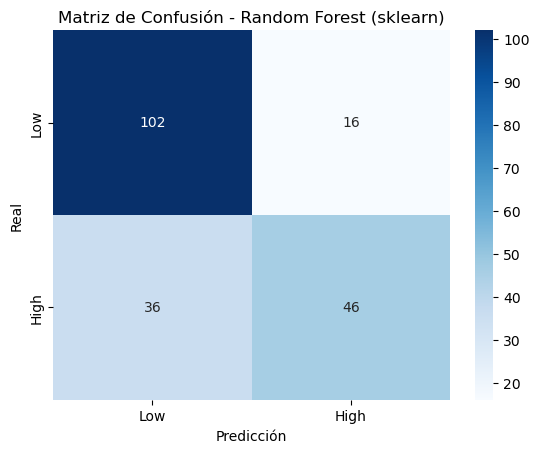

In [63]:
from sklearn.ensemble import RandomForestClassifier

# Construir el modelo
rf = RandomForestClassifier(n_estimators=10, random_state=0)

# Entrenar
rf.fit(X_train, y_train)

# Predecir
rf_pred = rf.predict(X_test)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, rf_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Low", "High"], yticklabels=["Low", "High"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Random Forest (sklearn)")
plt.show()


Using again the `sklearn` implementation, we will study the feature importance

<Axes: >

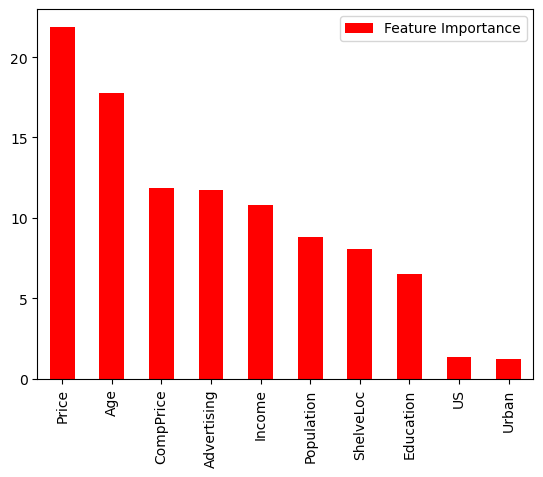

In [64]:
rf_featureImportance= pd.DataFrame({'Feature Importance':rf.feature_importances_*100}, index= X.columns)
rf_featureImportance.sort_values('Feature Importance', ascending=False).plot(kind='bar', color='red')

> Question: Given the models thus far (simple tree, bagging and RF), which one would you choose and why?
Con base en los modelos explorados (árbol simple, Bagging y Random Forest), yo elegiría Random Forest. Aunque un árbol simple es interpretable, suele sobreajustar o subajustar si no se ajustan bien sus parámetros. Bagging mejora la estabilidad reduciendo la varianza al combinar múltiples árboles, pero Random Forest va un paso más allá al introducir aleatoriedad en la selección de variables en cada división, lo que mejora aún más la generalización. Además, como se muestra en la gráfica, Random Forest permite analizar la importancia de las variables, ayudando a interpretar qué factores son más relevantes. Por tanto, Random Forest ofrece un excelente balance entre precisión, estabilidad y explicabilidad.

## Extra: Boosting

In order to fully complete our review of the ensemble methods from class, we are missing the **Boosting method**. In order to keep matters simple, we will implement it here with `sklearn` so that you get to see what it looks like...

In [65]:
# Import the model
from sklearn.ensemble import GradientBoostingClassifier

# Create the Boosting model
gb= GradientBoostingClassifier(n_estimators = 5000, random_state = 1, max_depth = 2)

# If you want to try it out, you can change reuse most of previous codes to run it here!

The results are pretty good! Keep in mind that this is achieved with super weak learners s.a. trees with depth 2. It is quite fast, and super easy to use with `sklearn`. We can also study the variable importance in this case.

In [66]:
gb_featureimportance= pd.DataFrame({'Feature Importance': gb.feature_importances_*100}, index= X.columns)
gb_featureimportance.sort_values('Feature Importance', ascending=False).plot(kind='bar', color='red')

NotFittedError: This GradientBoostingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

If you want to see how this can be implemented easily by hand, you can use the following code. We are using an implementation that follows a description of Boosting mode similar to the one given in the ISLR book

In [67]:
# Initialize the parameters
n_estimators = 1000  # Number of decision trees in the ensemble
learning_rate = 0.1  # Learning rate for each decision tree

# Initialize the weights for the training samples
sample_weights = np.ones(len(X_train)) / len(X_train)

# Train decision trees with weighted samples and make predictions
predictions = []
for _ in range(n_estimators):

    # Train a decision tree classifier on the weighted training samples
    decision_tree = DecisionTreeClassifier(max_depth = 2)
    decision_tree.fit(X_train, y_train, sample_weight=sample_weights)

    # Make predictions on the test set using the trained decision tree
    y_pred = decision_tree.predict(X_test)
    predictions.append(y_pred)

    # Calculate error
    incorrect = (y_pred != y_test).astype(int)
    error = np.sum(sample_weights * incorrect) / np.sum(sample_weights)

    # Update sample weights
    alpha = learning_rate * np.log((1 - error) / error)
    sample_weights *= np.exp(alpha * incorrect)

# Combine predictions
# For classification, you can use weighted voting
combined_predictions = np.zeros(len(X_test))
for prediction in predictions:
    combined_predictions += prediction

# Evaluate the performance of the boosting ensemble
# TODO: This can be done with the previous codes you had already. Reuse them here to see the result!